In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.stats import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
import scorecardpy as sc

In [2]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.4f}'.format

# Important Functions

In [3]:
'''SplitData function - used to divide a variable, according to the number of divided groups,
return a list of dividing point values'''
def SplitData(df,col,numOfSplit, special_attribute=[]):
    df2 = df.copy()
    if special_attribute != []:
        df2 = df2.loc[~df2[col].isin(special_attribute)]
    N = len(df2)
    n = int(N/numOfSplit)
    SplitPointIndex = [i*n for i in range(1,numOfSplit)]
    rawValues = sorted(list(df[col]))
    SplitPoint = [rawValues[i] for i in SplitPointIndex]
    SplitPoint = sorted(list(set(SplitPoint)))
    return SplitPoint


'''BinBadRate function - group by a variable, calculate the bad sample rate of each group after grouping, 
return a dictionary form, a data frame, and the overall bad sample rate (optional)'''

def BinBadRate(df,col,target,grantRateIndicator=0):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis =1)
    dicts = dict(zip(regroup[col], regroup['bad_rate']))
    
    if grantRateIndicator==0:
        return (regroup) #(dicts) , 
    else:
        N = sum(regroup['total'])
        B = sum(regroup['bad'])
        overallRate = B * 1.0/ N
        return (dicts, regroup, overallRate)

    
'''AssignGroup function - according to the grouped division point list, 
match each value of a variable to be binned before binning to form a mapping of the corresponding bins
'''    
def AssignGroup(x, bin):
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]

'''AssignBin function - bins and numbers each value of a column'''            
def AssignBin(x, cutOffPoints, special_attribute=[]):
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x) +1
        return 'Bin{}'.format(0-i)
    if x <= cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <= cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)


    

'''UnsupervisedSplitBin function - grouping numerical variables, 
the grouping is based on equal frequency and equal distance, and finally returns the list of division points
'''    
def UnsupervisedSplitBin(df,var,numOfSplit = 5, method = 'equal freq'):
    if method == 'equal fred':
        N = df.shape[0]
        n = N / numOfSplit
        splitPointIndex = [i * n for i in range(1, numOfSplit)]
        rawValues = sorted(list(df[var]))
        splitPoint = [rawValues[i] for i in splitPointIndex]
        splitPoint = sorted(list(set(splitPoint)))
        return splitPoint
    else:
        var_max, var_min = max(df[var]), min(df[var])
        interval_len = (var_max - var_min)*1.0/numOfSplit
        splitPoint = [var_min + i*interval_len for i in range(1, numOfSplit)]
        return splitPoint

    
'''BadRateEncoding function - used to encode categorical variables with BadRate, 
and return the bad sample rate corresponding to each value of the column
'''    
def BadRateEncoding(df,col,target):
    regroup = BinBadRate(df, col, target, grantRateIndicator=0)[1]
    br_dict = regroup[[col,'bad_rate']].set_index([col]).to_dict(orient='index')
    for k, v in br_dict.items():
        br_dict[k] = v['bad_rate']
    BadRateEncoding = df[col].map(lambda x: br_dict[x])
    return {'encoding':BadRateEncoding, 'bad_rate':br_dict}

'''CalcWOE function - perform WOE calculation and IV value calculation on the binning result of a variable, 
and finally return the WOE value corresponding to each box of the variable and the IV value of the variable
'''
def CalcWOE(df, col, target):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total']-regroup['bad']
    G = N-B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0/G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt), axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict,'IV':IV}
                         


# Data reading/cleaning

In [4]:
lending_data = pd.read_csv("C:/Users/HOANG HIEP/Downloads/LoanStats_2019Q1.csv")
data = lending_data.copy()
data.head()

G:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,nan,nan,20475,20475,20475.0000,36 months,20.00%,760.9300,D,D2,NaN,< 1 year,MORTGAGE,118610.0000,Source Verified,3/19/2022,Charged Off,n,nan,nan,debt_consolidation,Debt consolidation,361xx,AL,26.5100,0,7/13/2022,0,nan,nan,8,0,9577,62.60%,14,w,0.0000,0.0000,20760.1300,20760.1300,12749.0800,6609.1500,0.0000,1401.9000,252.3420,21-Dec,0.0000,NaN,21-Mar,0,nan,1,Joint App,176610.0000,18.5700,Source Verified,0,0,109036,0,4,1,3,10.0000,99459,88.0000,0,2,6340,82.0000,15300,1,2,0,5,13630.0000,660.0000,90.6000,0,0,68.0000,40,18,10,0,40.0000,nan,14.0000,nan,0,1,3,1,1,9,4,5,3,8,0.0000,0,0,1,100.0000,100.0000,0,0,146022,109036,7000,130722,49531.0000,6-Sep,0.0000,3.0000,10.0000,79.8000,3.0000,6.0000,0.0000,0.0000,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,nan
1,nan,nan,10000,10000,10000.0000,36 months,8.81%,317.1200,A,A5,NaN,< 1 year,MORTGAGE,36000.0000,Not Verified,3/19/2022,Fully Paid,n,nan,nan,debt_consolidation,Debt consolidation,430xx,OH,23.1700,0,11/5/2022,0,nan,nan,8,0,8965,41.70%,11,w,0.0000,0.0000,11486.7800,11486.7800,10000.0000,1486.7800,0.0000,0.0000,0.0000,21-Sep,3783.5700,NaN,21-Mar,0,nan,1,Individual,nan,nan,NaN,0,0,93521,0,1,0,1,17.0000,7396,61.0000,1,3,4045,49.0000,21500,1,0,0,4,11690.0000,7458.0000,52.8000,0,0,133.0000,160,12,12,2,12.0000,nan,17.0000,nan,0,3,4,3,3,3,5,6,4,8,0.0000,0,0,1,90.9000,0.0000,0,0,132718,16361,15800,12225,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,nan
2,nan,nan,6500,6500,6475.0000,36 months,8.81%,206.1300,A,A5,Service Technician,10+ years,OWN,85000.0000,Source Verified,3/19/2022,Fully Paid,n,nan,nan,debt_consolidation,Debt consolidation,85

Text(0.5, 0, 'Phần trăm')

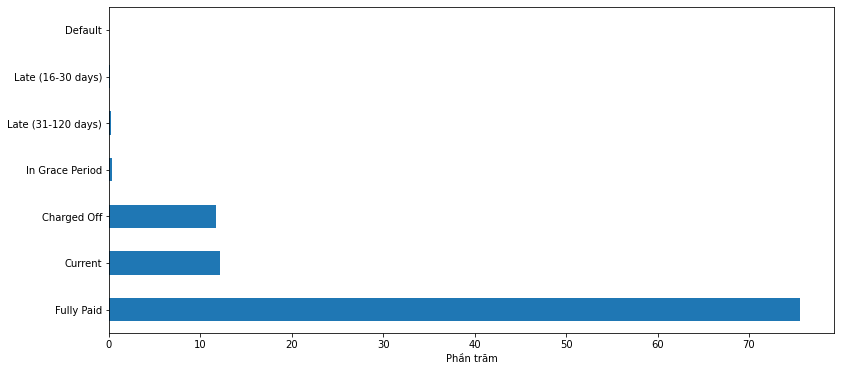

In [5]:
plt.rcParams["figure.figsize"] = (13,6)
((lending_data['loan_status'].value_counts()/lending_data.shape[0])*100).plot(kind="barh")
plt.xlabel('Phần trăm')
#plt.rcParams.update({'font.size': 5})

In [6]:
data['loan_status']=data['loan_status'].replace(['Fully Paid','In Grace Period','Late (31-120 days)','Late (16-30 days)','Charged Off','Default'],
                                               ['0','1','1','1','1','1'])
data = data[data['loan_status'].isin(['0','1'])]
data['loan_status'] = data['loan_status'].astype('int')

In [7]:
data.shape

(101537, 144)

<AxesSubplot:ylabel='loan_status'>

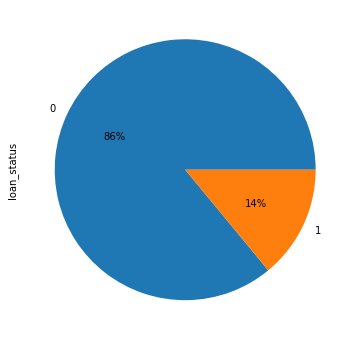

In [8]:
#Tỉ lệ good/bad
(data['loan_status'].value_counts()/len(data)).plot(kind='pie',autopct= '%1.0f%%')

In [9]:
((data.isnull().sum()/len(data))*100).sort_values(ascending=False)

id                                           100.0000
desc                                         100.0000
member_id                                    100.0000
url                                          100.0000
orig_projected_additional_accrued_interest    99.8798
hardship_type                                 99.8661
hardship_last_payment_amount                  99.8661
hardship_payoff_balance_amount                99.8661
hardship_reason                               99.8661
hardship_loan_status                          99.8661
hardship_dpd                                  99.8661
hardship_length                               99.8661
payment_plan_start_date                       99.8661
hardship_end_date                             99.8661
hardship_start_date                           99.8661
hardship_amount                               99.8661
deferral_term                                 99.8661
hardship_status                               99.8661
settlement_percentage       

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143]),
 [Text(0, 0, 'inq_fi'),
  Text(1, 0, 'delinq_amnt'),
  Text(2, 0, 'chargeoff_within_12_mths'),
  Text(3, 0, 'acc_open_past_24mths'),
  Text(4, 0, 'inq_last_12m'),
  Text(5, 0, 'total

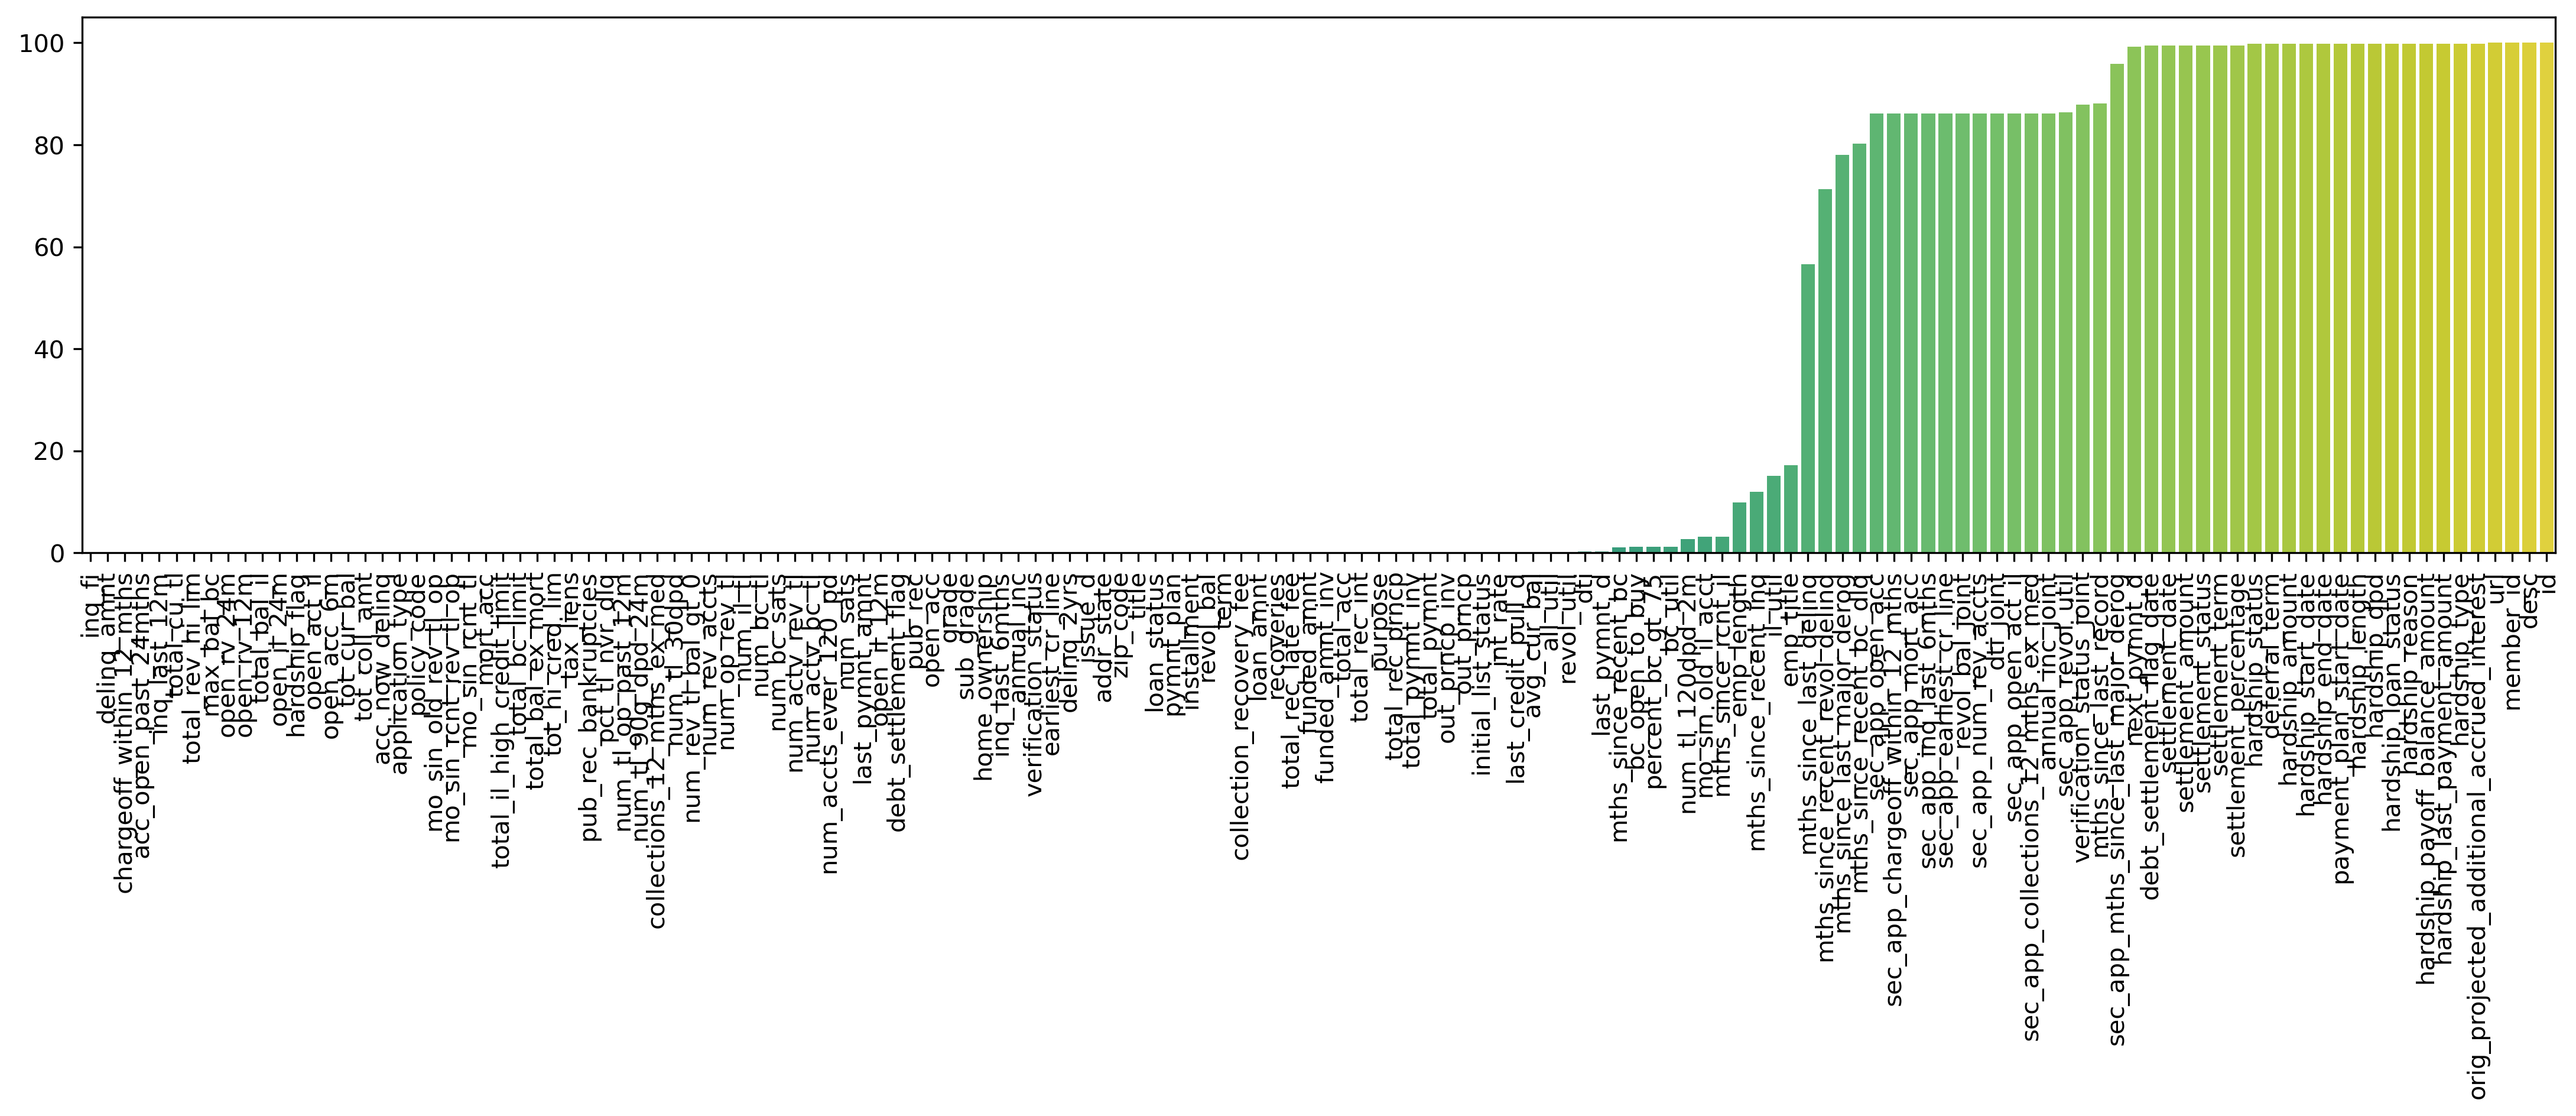

In [10]:
#Xem tỉ lệ missing
plt.figure(figsize=(18,4),dpi=300)
sns.barplot(y=((data.isnull().sum()/len(data))*100).sort_values(), 
            x=((data.isnull().sum()/len(data))*100).sort_values().index, palette='viridis') 
plt.xticks(rotation=90)

In [11]:
#loại bỏ những biến null > 70%
null_cols = data.isna().sum().sort_values(ascending=False)/float(data.shape[0])
null_cols = null_cols[null_cols > 0.7]
data = data.loc[:, ~data.columns.isin(list(null_cols.index.values))]

#loại bỏ các biến ko liên quan
names=['sub_grade','emp_title','pymnt_plan','title','zip_code','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
      'last_credit_pull_d','collections_12_mths_ex_med','policy_code','acc_now_delinq','num_tl_120dpd_2m','num_tl_30dpd','hardship_flag',
      'funded_amnt','funded_amnt_inv','out_prncp_inv','total_pymnt','total_pymnt_inv','out_prncp','total_rec_prncp','total_rec_int','mths_since_last_delinq']
data=data.drop(names, axis=1)


In [12]:
data[['emp_length','int_rate','issue_d',
        'delinq_2yrs','revol_bal','total_acc','revol_util','earliest_cr_line']].dtypes

emp_length          object
int_rate            object
issue_d             object
delinq_2yrs          int64
revol_bal            int64
total_acc            int64
revol_util          object
earliest_cr_line    object
dtype: object

In [13]:
data=data.drop(data[data['earliest_cr_line'] == '1900/1/0'].index)
data['int_rate']= data['int_rate'].str.replace('%','').astype('float')
data['revol_util']=data['revol_util'].str.replace('%','').astype('float')

data['emp_length']=data['emp_length'].fillna('0')
data['emp_length']=data['emp_length'].str.replace(' year','')
data['emp_length']=data['emp_length'].str.replace('s','')
data['emp_length']=data['emp_length'].replace(['10+','< 1'],['11','0']).astype('int')

data['delinq_2yrs']=data['delinq_2yrs'].astype('int')
data['revol_bal']=data['revol_bal'].astype('int')
data['total_acc']=data['total_acc'].astype('int')

In [14]:
#tạo ra biến mới mth_interval
data['issue_d']=pd.to_datetime(data['issue_d'],format='%m/%d/%Y')
data['earliest_cr_line']=pd.to_datetime(data['earliest_cr_line'],format='%m/%d/%Y')
data['mth_interval']=data['issue_d']-data['earliest_cr_line']
data['mth_interval']=data['mth_interval'].apply(lambda x:  round(x.days/30,0))
#Tạo biến issue_m
data['issue_m']=data['issue_d'].apply(lambda x: x.month)
#tạo ra biến mới income_vs_loan
data['income_vs_loan']=data['annual_inc']/data['loan_amnt']
#drop các biến cũ
data=data.drop(['issue_d','earliest_cr_line'],axis=1)
#drop các biến có mức độ tập trung cao
data=data.drop(['tax_liens','debt_settlement_flag'],axis=1)

In [15]:
na_cols=data.isna().sum()[data.isna().sum() > 0].index.values
print(data[na_cols].dtypes)

'''for col in na_cols:
    mean = data[col].mean()
    data[col] = data[col].fillna(mean, inplace=True)'''

data.fillna(value = data.mean(), inplace=True)

dti                      float64
revol_util               float64
mths_since_rcnt_il       float64
il_util                  float64
all_util                 float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_il_acct       float64
mths_since_recent_bc     float64
mths_since_recent_inq    float64
percent_bc_gt_75         float64
dtype: object


In [16]:
num_features =[]
obj_features =[]
for i in data.columns.values:
    if data[i].dtypes == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

#fig,ax = plt.subplots(figsize=(20,20))
#sns.heatmap(data[num_features].corr().round(2))
#cor = data[num_features].corr()[np.abs(data[num_features].corr()) < 0.6]
#cor

# After cleaning, split train/test

In [17]:
train, test = sc.split_df(data, 'loan_status').values()

print(train.shape)
print(test.shape)

(71076, 74)
(30461, 74)


In [18]:
#tách Train/Test thành biến độc lập X và y
y_train = train.loc[:,'loan_status']
X_train = train.loc[:,train.columns != 'loan_status']
y_test = test.loc[:,'loan_status']
X_test = test.loc[:,train.columns != 'loan_status']

# Fine classing

#### Hàm tính WOE cho biến discrete

In [19]:
#Hàm tính WOE cho các biến categorical
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['n_good'] = (1 - df['prop_bad']) * df['n_obs']
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    #df['diff_prop_good'] = df['prop_good'].diff().abs()
    #df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV_each'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = np.ma.masked_invalid(df['IV_each']).sum()
    return df

#### Hàm tính WOE cho biến liên tục

In [20]:
#Hàm tính WOE cho các biến numerical/continuous
#continuous
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['n_good'] = (1 - df['prop_bad']) * df['n_obs']
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    #df['diff_prop_good'] = df['prop_good'].diff().abs()
    #df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV_each'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV_each'].sum()  
    return df

#### Hàm plot WOE của biến

In [21]:
#Vẽ biểu đồ WOE của các biến
sns.set()
def plot_by_woe(col, train=0, rotation_of_x_axis_labels = 0):
    if train == 0:
        df_WoE = fine_class_train[col]
    else:
        df_WoE = fine_class_test[col]
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

#### Hàm trả ra Fine Classing 20-30 bins tùy theo số lượng mình chọn

In [22]:
#df1: X_train ; df2: y_train ; df3: X_test ; df4: y_test

def Fine_Classing(df1, df2, df3 = None, df4 = None, train=0):
    '''Khi cần xem Fine-classing của tập train, điền:
       df1 = X_train / df2 = y_train
       Khi cần xem Fine-classing của tập test, điền:
       df1 = X_train / df2 = y_train / df3 = X_test / df4 = y_test
           lý do xem của test nhưng vẫn phải điền X,y_train bởi phải bin theo bin của tập train'''
    df_x = df1.copy()
    df_y = df2.copy()
    num_features =[]
    obj_features =[]
    for i in df_x.columns.values:
        if df_x[i].dtypes == 'object':
            obj_features.append(i)
        else:
            num_features.append(i)
    fine_classing = {}
    keys = []
    values = []
    if train == 0:
        for col in df_x.columns.values:
            if col in num_features:
                point = SplitData(df_x,col,20)
                cut_bin = [float('-inf')]
                cut_bin.extend(point)
                cut_bin.extend([float('+inf')])
                df_x[col + '_bins'] = pd.cut(df_x[col],bins =cut_bin,right=False,labels =None )
                df_woe2 = woe_ordered_continuous(df_x, col + '_bins', df_y)
                df_woe2 = df_woe2.replace(np.nan,0)
                keys.append(col)
                values.append(df_woe2)
                for i in range(len(keys)):
                    fine_classing[keys[i]] = values[i]
            if col in obj_features:
                df_woe1 = woe_discrete(df_x, col, df_y)
                #df_woe1 = df_woe1.sort_values(df_woe1.columns[0], ascending = True)
                #df_woe1 = df_woe1.reset_index(drop = True)
                keys.append(col)
                values.append(df_woe1)
                for i in range(len(keys)):
                    fine_classing[keys[i]] = values[i]
    else:
        df_x_test = df3.copy()
        df_y_test = df4.copy()
        for col in df_x_test.columns.values:
            if col in num_features:
                point = SplitData(df_x,col,20)
                cut_bin = [float('-inf')]
                cut_bin.extend(point)
                cut_bin.extend([float('+inf')])
                df_x_test[col + '_bins'] = pd.cut(df_x_test[col],bins =cut_bin,right=False,labels =None )
                df_woe2 = woe_ordered_continuous(df_x_test, col + '_bins', df_y_test)
                df_woe2 = df_woe2.replace(np.nan,0)
                keys.append(col)
                values.append(df_woe2)
                for i in range(len(keys)):
                    fine_classing[keys[i]] = values[i]
            if col in obj_features:
                df_woe1 = woe_discrete(df_x_test, col, df_y_test)
                #df_woe1 = df_woe1.sort_values(df_woe1.columns[0], ascending = True)
                #df_woe1 = df_woe1.reset_index(drop = True)
                keys.append(col)
                values.append(df_woe1)
                for i in range(len(keys)):
                    fine_classing[keys[i]] = values[i]        
    return fine_classing

In [23]:
fine_class_test = Fine_Classing(X_train, y_train, X_test, y_test, train=1)
fine_class_train = Fine_Classing(X_train, y_train)

In [24]:
fine_class_train['loan_amnt']

,loan_amnt_bins,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_bad,prop_n_good,WoE,IV_each,IV
0,"[-inf, 3200.0)",3455,0.0906,0.0486,313.0000,3142.0000,0.0314,0.0514,0.4926,0.0098,0.0658
1,"[3200.0, 5000.0)",3141,0.0914,0.0442,287.0000,2854.0000,0.0288,0.0467,0.4831,0.0086,0.0658
2,"[5000.0, 6000.0)",3971,0.1070,0.0559,425.0000,3546.0000,0.0427,0.0580,0.3076,0.0047,0.0658
3,"[6000.0, 7000.0)",3444,0.0999,0.0485,344.0000,3100.0000,0.0345,0.0507,0.3847,0.0062,0.0658
4,"[7000.0, 8000.0)",2467,0.1062,0.0347,262.0000,2205.0000,0.0263,0.0361,0.3163,0.0031,0.0658
5,"[8000.0, 10000.0)",4666,0.1022,0.0656,477.0000,4189.0000,0.0479,0.0685,0.3589,0.0074,0.0658
6,"[10000.0, 12000.0)",9913,0.1485,0.1395,1472.0000,8441.0000,0.1477,0.1381,-0.0674,0.0006,0.0658
7,"[12000.0, 13000.0)",3911,0.1370,0.0550,536.0000,3375.0000,0.0538,0.0552,0.0262,0.0000,0.0658
8,"[13000.0, 15000.0)",2596,0.1364,0.0365,354.0000,2242.0000,0.0355,0.0367,0.0320,0.0000,0.0658
9,"[15000.0, 16000.0)",4527,0.1427,0.0637,646.0000,3881.0000,0.0648,0.0635,-0.0208,0.0000,0.0658


#### Tính CSI dựa trên fine-classing của 2 tập train/test chia bin giống nhau đã tạo ở trên

In [25]:
#Tính CSI các biến
CSI_name = []
CSI_value = []
for i in X_train.columns.values:
    A = fine_class_train[i].sort_values(fine_class_train[i].columns[0], ascending=True).reset_index(drop = True)['prop_n_obs']
    B = fine_class_test[i].sort_values(fine_class_train[i].columns[0], ascending=True).reset_index(drop = True)['prop_n_obs']
    CSI = sum(((A-B) * np.log(A/B)).replace(np.nan,0))
    CSI_name.append(i)
    CSI_value.append(CSI)
CSI_df = pd.DataFrame(
                {'Variable': CSI_name,
                 'CSI': CSI_value})
CSI_df.round(6)

,Variable,CSI
0,loan_amnt,0.0004
1,term,0.0002
2,int_rate,0.0007
3,installment,0.0010
4,grade,0.0005
5,emp_length,0.0002
6,home_ownership,1.3337
7,annual_inc,0.0006
8,verification_status,0.0001
9,purpose,0.0005


#### Danh sách các biến có IV yếu

In [26]:
weak_IV = []
for i in X_train.columns.values:
    if fine_class_train[i]['IV'][0] < 0.01:
        weak_IV.append(i)
print(len(weak_IV))     
print(weak_IV)

30
['delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'tot_coll_amt', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'total_cu_tl', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'issue_m']


#### Danh sách các biến có CSI cao

In [27]:
high_CSI = []
for i in X_train.columns.values:
    if CSI_df.loc[CSI_df['Variable'] == i, 'CSI'].iloc[0] > 0.25:
        high_CSI.append(i)

print(high_CSI)

['home_ownership']


#### Loại bỏ các biến IV yếu và CSI cao

In [28]:
train_prep = train.drop(columns = weak_IV)
train_prep = train.drop(columns = high_CSI)
test_prep = test.drop(columns = weak_IV)
test_prep = test.drop(columns = high_CSI)

# Coarse classing

#### Sử dụng Scorecardpy

In [29]:
#Coarse classing 
breaks_adj = {'acc_open_past_24mths':[3.0,4,0,8.0]
              ,'all_util':[30.0,40.0,60.0]
              ,'annual_inc':[40000.0,100000.0,170000.0]
              ,'avg_cur_bal':[8000.0,16000.0,36000.0]
              ,'bc_util':[35.0,50.0]
              ,'grade':['A','B','C','D%,%E%,%F%,%G']
              ,'il_util':[45.0,65.0]
              ,'income_vs_loan':[2.5,4.5,8.0]
              ,'inq_last_12m':[1.0,2.0,4.0]
              ,'installment':[200.0,500.0,650.0,1150.0]
              ,'loan_amnt':[10000.0,19000.0]
              ,'max_bal_bc':[6500.0,11500.0,14500.0]
              ,'mo_sin_old_rev_tl_op':[60.0,80.0,140.0,170.0]
              ,'mo_sin_old_il_acct':[50.0,90.0,150.0]
              ,'mth_interval':[70.0,150.0,220.0]
              ,'mths_since_rcnt_il':[5.0,11.0,15.0,18.0,22.0]
              ,'mths_since_recent_bc':[6.0,18.0,30.0,50.0]
              ,'mths_since_recent_inq':[3.0,5.0,7.0]
              ,'num_il_tl':[2.0,3.0,5.0]
              ,'open_rv_24m':[2.0,3.0,5.0]
              ,'revol_bal':[28000.0,37000.0]
              #,'tot_hi_cred_lim':[16000.0,100000.0]
              ,'total_acc':[12.0,16.0]
              ,'total_bax_ex_mort':[45000.0,85000.0,135000.0]
              ,'addr_state':['ME%,%WV%,%WY%,%DE%,%DC%,%NH%,%OR%,%ID%,%MI%,%AK%,%VT%,%CO%,%WA%,%MT%,%SC%,%RI%,%VA%,%WI',
                            'OH%,%MN%,%NC%,%MO%,%KY%,%UT%,%IL%,%IN%,%GA',
                            'MA%,%NJ%,%AZ%,%AR%,%TX%,%MD',
                            'AL%,%CA%,%CT%,%NM%,%TN',
                            'PA%,%LA%,%KS%,%NY%,%MS%,%OK%,%FL%,%NE%,%SD%,%HI%,%ND%,%NV']
              ,'num_accts_ever_120_pd':[1.0,2.0]
              ,'num_bc_sats':[5.0,10.0]
              ,'chargeoff_within_12_mths':[2.0,5.0]
              ,'num_tl_90g_dpd_24m':[4.0,8.0,12.0,16.0]
              ,'delinq_amnt':[13000.0,26000.0,39000.0,52000.0]
              #,'total_bal_il':[250000.0,504000.0,756000.0,1008000.0]
              ,'total_cu_tl':[1.0,3.0,4.0]}


In [30]:
bins = sc.woebin(train_prep, y="loan_status",breaks_list=breaks_adj)

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
addr_state
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 71076 rows and 73 columns in 00:01:56


In [86]:
#sc.woebin_plot(bins)

In [32]:
#loại bỏ các biến ko có trend
train_prep = train_prep.loc[:, ~train_prep.columns.isin(['dti','num_op_rev_tl','installment'])]
test_prep = test_prep.loc[:, ~test_prep.columns.isin(['dti','num_op_rev_tl','installment'])]

#### BIN TABLE

In [33]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

bin_data = []
data1 = train_prep.loc[:, ~train_prep.columns.isin(['loan_status'])]

for col in data1.columns.values:
    df_bins = bins[col]
    bin_data.append(df_bins)
    bin_data_df = pd.concat(bin_data)

#xem bin table    
bin_data_df = bin_data_df.loc[:,bin_data_df.columns != 'breaks']
bin_data_df

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,is_special_values
0,loan_amnt,"[-inf,10000.0)",21144,0.29748,19036,2108,0.09970,-0.38675,0.03864,0.06092,False
1,loan_amnt,"[10000.0,19000.0)",25719,0.36185,22033,3686,0.14332,0.02585,0.00024,0.06092,False
2,loan_amnt,"[19000.0,inf)",24213,0.34066,20044,4169,0.17218,0.24359,0.02204,0.06092,False
0,term,36 months,54135,0.76165,48165,5970,0.11028,-0.27404,0.05177,0.17219,False
1,term,60 months,16941,0.23835,12948,3993,0.23570,0.63745,0.12042,0.17219,False
0,int_rate,"[-inf,9.0)",24354,0.34265,22784,1570,0.06447,-0.86114,0.18535,0.34703,False
1,int_rate,"[9.0,12.0)",14072,0.19799,12456,1616,0.11484,-0.22840,0.00951,0.34703,False
2,int_rate,"[12.0,17.0)",20616,0.29006,16952,3664,0.17773,0.28202,0.02549,0.34703,False
3,int_rate,"[17.0,inf)",12034,0.16931,8921,3113,0.25868,0.76103,0.12670,0.34703,False
0,grade,A,24339,0.34244,22770,1569,0.06446,-0.86116,0.18524,0.34812,False


#### Bảng WOE

In [34]:
#Xem WOE các biến
woe_screen = bin_data_df[['variable','bin','woe']].drop_duplicates()
woe_screen

,variable,bin,woe
0,loan_amnt,"[-inf,10000.0)",-0.38675
1,loan_amnt,"[10000.0,19000.0)",0.02585
2,loan_amnt,"[19000.0,inf)",0.24359
0,term,36 months,-0.27404
1,term,60 months,0.63745
0,int_rate,"[-inf,9.0)",-0.86114
1,int_rate,"[9.0,12.0)",-0.22840
2,int_rate,"[12.0,17.0)",0.28202
3,int_rate,"[17.0,inf)",0.76103
0,grade,A,-0.86116


#### Bảng IV

In [35]:
#xem IV cua cac bien
iv_screen = bin_data_df[['variable','total_iv']].drop_duplicates()
iv_screen

,variable,total_iv
0,loan_amnt,0.06092
0,term,0.17219
0,int_rate,0.34703
0,grade,0.34812
0,emp_length,0.02914
0,annual_inc,0.01323
0,verification_status,0.02354
0,purpose,0.00860
0,addr_state,0.01991
0,delinq_2yrs,0.00015


#### Loại bỏ các IV < 0.02

In [36]:
weak_var = list(iv_screen['variable'][iv_screen['total_iv'] < 0.02].values)
weak_var

['annual_inc',
 'purpose',
 'addr_state',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'tot_coll_amt',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_90g_dpd_24m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'mth_interval',
 'issue_m']

In [37]:
len(weak_var)

46

In [38]:
#List các biến bị loại do IV yếu
#ac = iv_screen[iv_screen['variable'].isin([i for i in weak_var if i not in ('annual_inc','addr_state',)])]
#ac.to_csv(r'D:/Users/hiepbh.ctv/Documents/Python files/Lending club project/IV eliminate.csv')

In [39]:
#Loại bỏ các biến IV yếu, ngoại trừ các biến quan trọng
train_prep = train_prep.loc[:, ~train_prep.columns.isin([i for i in weak_var if i not in ('annual_inc')])]
test_prep = test_prep.loc[:, ~test_prep.columns.isin([i for i in weak_var if i not in ('annual_inc')])]

In [40]:
train_prep.shape

(71076, 25)

#### CORRELATION

In [41]:
#CORRELATION
data2 = train_prep.loc[:, ~train_prep.columns.isin(['loan_status'])]
c = data2.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")
dff = pd.DataFrame(so)
dff

0
emp_length            open_rv_24m           0.00022
open_rv_24m           emp_length            0.00022
                      annual_inc            0.00052
annual_inc            open_rv_24m           0.00052
mo_sin_rcnt_tl        avg_cur_bal           0.00057
avg_cur_bal           mo_sin_rcnt_tl        0.00057
annual_inc            open_rv_12m           0.00126
open_rv_12m           annual_inc            0.00126
tot_hi_cred_lim       mo_sin_rcnt_rev_tl_op 0.00156
mo_sin_rcnt_rev_tl_op tot_hi_cred_lim       0.00156
                      income_vs_loan        0.00198
income_vs_loan        mo_sin_rcnt_rev_tl_op 0.00198
open_rv_12m           emp_length            0.00306
emp_length            open_rv_12m           0.00306
open_rv_24m           tot_hi_cred_lim       0.00388
tot_hi_cred_lim       open_rv_24m           0.00388
emp_length            mths_since_recent_inq 0.00457
mths_since_recent_inq emp_length            0.00457
annual_inc            mo_sin_rcnt_rev_tl_op 0.00504
mo_sin_rcnt_rev_tl_op annual_inc            0.00504
tot_hi_cred_lim       open_rv_12m           0.00504
open_rv_12m           tot_hi_cred_lim       0.00504
loan_amnt             mths_since_recent_inq 0.00532
mths_since_recent_inq loan_amnt             0.00532
acc_open_past_24mths  loan_amnt             0.00696
loan_amnt             acc_open_past_24mths  0.00696
emp_length            inq_last_6mths        0.00698
inq_last_6mths        emp_length            0.00698
open_rv_24m           income_vs_loan        0.00801
income_vs_loan        open_rv_24m           0.00801
annual_inc            mths_since_recent_bc  0.00867
mths_since_recent_bc  annual_inc            0.00867
emp_length            inq_last_12m          0.00948
inq_last_12m          emp_length            0.00948
open_rv_12m           income_vs_loan        0.01139
income_vs_loan        open_rv_12m           0.01139
mo_sin_rcnt_rev_tl_op tot_cur_bal           0.01171
tot_cur_bal           mo_sin_rcnt_rev_tl_op 0.01171
mths_since_recent_bc  income_vs_loan        0.01228
income_vs_loan        mths_since_recent_bc  0.01228
loan_amnt             inq_last_12m          0.01334
inq_last_12m          loan_amnt             0.01334
mo_sin_rcnt_rev_tl_op emp_length            0.01351
emp_length            mo_sin_rcnt_rev_tl_op 0.01351
avg_cur_bal           open_acc_6m           0.01411
open_acc_6m           avg_cur_bal           0.01411
mo_sin_old_rev_tl_op  inq_last_6mths        0.01626
inq_last_6mths        mo_sin_old_rev_tl_op  0.01626
int_rate              loan_amnt             0.01634
loan_amnt             int_rate              0.01634
income_vs_loan        int_rate              0.01645
int_rate              income_vs_loan        0.01645
                      emp_length            0.01653
emp_length            int_rate              0.01653
tot_cur_bal           open_rv_12m           0.01844
open_rv_12m           tot_cur_bal           0.01844
income_vs_loan        mo_sin_old_rev_tl_op  0.01873
mo_sin_old_rev_tl_op  income_vs_loan        0.01873
mths_since_recent_bc  tot_hi_cred_lim       0.01880
tot_hi_cred_lim       mths_since_recent_bc  0.01880
mort_acc              open_rv_12m           0.01932
open_rv_12m           mort_acc              0.01932
mo_sin_old_rev_tl_op  mths_since_recent_inq 0.02052
mths_since_recent_inq mo_sin_old_rev_tl_op  0.02052
mo_sin_rcnt_rev_tl_op mort_acc              0.02063
mort_acc              mo_sin_rcnt_rev_tl_op 0.02063
open_acc_6m           mo_sin_old_rev_tl_op  0.02110
mo_sin_old_rev_tl_op  open_acc_6m           0.02110
avg_cur_bal           num_tl_op_past_12m    0.02173
num_tl_op_past_12m    avg_cur_bal           0.02173
loan_amnt             mths_since_recent_bc  0.02173
mths_since_recent_bc  loan_amnt             0.02173
emp_length            mths_since_recent_bc  0.02222
mths_since_recent_bc  emp_length            0.02222
avg_cur_bal           mths_since_recent_inq 0.02307
mths_since_recent_inq avg_cur_bal           0.02307
loan_amnt             mo_sin_rcnt_tl        0.

In [42]:
#Loại bỏ biến tương quan cao
train_prep = train_prep.loc[:, ~train_prep.columns.isin(['tot_cur_bal'])]
test_prep = test_prep.loc[:, ~test_prep.columns.isin(['tot_cur_bal'])]

In [43]:
train_woe = sc.woebin_ply(train_prep, bins)
test_woe = sc.woebin_ply(test_prep, bins)

[INFO] converting into woe values ...
Woe transformating on 71076 rows and 23 columns in 00:00:12
[INFO] converting into woe values ...


In [44]:
print(train_woe.shape)
print(test_woe.shape)

(71076, 24)
(30461, 24)


In [45]:
#Bỏ biến có p_value cao
train_woe = train_woe.loc[:, ~train_woe.columns.isin(['num_tl_op_past_12m_woe','annual_inc_woe','open_acc_6m_woe'
                                                              ,'avg_cur_bal_woe','open_rv_12m_woe','mo_sin_rcnt_rev_tl_op_woe'
                                                              ,'mort_acc_woe'])]
test_woe = test_woe.loc[:, ~test_woe.columns.isin(['num_tl_op_past_12m_woe','annual_inc_woe','open_acc_6m_woe'
                                                              ,'avg_cur_bal_woe','open_rv_12m_woe','mo_sin_rcnt_rev_tl_op_woe'
                                                              ,'mort_acc_woe'])]

#### VIF

In [46]:
train_woe_vif = train_woe.loc[:, ~train_woe.columns.isin(['loan_status'])]
def VIF_cal(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    max_VIF = max(VIF_list)
    print(max_VIF)
    return VIF

In [47]:
VIF_cal(train_woe_vif)

19.935990017133967


,feature,VIF
0,emp_length_woe,1.05010
1,verification_status_woe,1.11373
2,loan_amnt_woe,1.90818
3,inq_last_6mths_woe,2.06354
4,mths_since_recent_bc_woe,1.47489
5,grade_woe,19.83170
6,open_rv_24m_woe,2.67051
7,inq_last_12m_woe,1.84538
8,int_rate_woe,19.93599
9,mo_sin_old_rev_tl_op_woe,1.12079


In [48]:
#Bỏ biến có VIF cao
train_woe = train_woe.loc[:, ~train_woe.columns.isin(['int_rate_woe','grade_woe'])]
test_woe = test_woe.loc[:, ~test_woe.columns.isin(['int_rate_woe','grade_woe'])]

In [49]:
#Bỏ biến thiếu ý nghĩa
train_woe = train_woe.loc[:, ~train_woe.columns.isin(['inq_last_12m_woe','mo_sin_old_rev_tl_op_woe',
                                          'verification_status_woe','mths_since_recent_inq_woe','mo_sin_rcnt_tl'
                                          'open_rv_24m_woe','term_woe','tot_hi_cred_lim_woe'
                                          #,'inq_last_6mths_woe','acc_open_past_24mths_woe'               
                                                     ])]
test_woe = test_woe.loc[:, ~test_woe.columns.isin(['inq_last_12m_woe','mo_sin_old_rev_tl_op_woe',
                                          'verification_status_woe','mths_since_recent_inq_woe','mo_sin_rcnt_tl'
                                          'open_rv_24m_woe','term_woe','tot_hi_cred_lim_woe'
                                          #,'inq_last_6mths_woe','acc_open_past_24mths_woe'               
                                                     ])]

In [50]:
#tách Train/Test thành biến độc lập X và y
y_train_woe = train_woe.loc[:,'loan_status']
X_train_woe = train_woe.loc[:,train_woe.columns != 'loan_status']
y_test_woe = test_woe.loc[:,'loan_status']
X_test_woe = test_woe.loc[:,test_woe.columns != 'loan_status']

## LOGISTIC REGRESSION

In [51]:
# Cách 1 dùng statmodels logit
#X_train_woe=sm.add_constant(X_train_woe)
#logit=sm.Logit(y_train_woe,X_train_woe).fit()
#logit.summary()

In [52]:
#Cách 2
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42,penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train_woe, y_train_woe)
lr_result = pd.DataFrame({'Variable':X_train_woe.columns.values, 'Coef':lr.coef_[0]})
#lr_result.loc[-1] = ['constant', lr.intercept_[0]] 

print(lr.intercept_)
lr_result

[-1.8140553]


,Variable,Coef
0,emp_length_woe,0.99619
1,loan_amnt_woe,0.50435
2,inq_last_6mths_woe,0.75428
3,mths_since_recent_bc_woe,0.28395
4,open_rv_24m_woe,0.41606
5,mo_sin_rcnt_tl_woe,0.28302
6,income_vs_loan_woe,0.84676
7,acc_open_past_24mths_woe,0.46162


# Scorecard

#### Cách 1: Tự tính theo công thức

In [54]:
pdo = 50 
base = 500 
odds = 20 
factor = round(pdo/np.log(2)) #b 
offset = round(base-(factor*np.log(odds))) #a 

In [100]:
last_var = []
coef_list = []
for i in X_train_woe.columns.values:
    last_var.append(i[:-4])
for x in last_var:
    coef_list.append(lr_result[lr_result['Variable'] == x+'_woe']['Coef'].values[0])
coef_df = pd.DataFrame({'variable':last_var,'coef':coef_list})
last_var_woe = woe_screen[woe_screen['variable'].isin(last_var)]
last_var_woe = last_var_woe.merge(coef_df,how='left', on='variable')
last_var_woe['score']=round((last_var_woe['woe']*last_var_woe['coef']*factor*-1),0)
last_var_woe.loc[-1] = ['basescore', 'NaN', 'NaN',lr.intercept_[0],round(offset - factor*(lr.intercept_[0]), 0)]
last_var_woe.index = last_var_woe.index + 1  # shifting index
last_var_woe = last_var_woe.sort_index()

#### Thẻ điểm 1:

In [101]:
last_var_woe

,variable,bin,woe,coef,score
0,basescore,NaN,NaN,-1.81406,415.00000
1,loan_amnt,"[-inf,10000.0)",-0.38675,0.50435,14.00000
2,loan_amnt,"[10000.0,19000.0)",0.02585,0.50435,-1.00000
3,loan_amnt,"[19000.0,inf)",0.24359,0.50435,-9.00000
4,emp_length,"[-inf,1.0)",0.27434,0.99619,-20.00000
5,emp_length,"[1.0,4.0)",0.00561,0.99619,-0.00000
6,emp_length,"[4.0,7.0)",-0.09412,0.99619,7.00000
7,emp_length,"[7.0,inf)",-0.15617,0.99619,11.00000
8,inq_last_6mths,"[-inf,1.0)",-0.11839,0.75428,6.00000
9,inq_last_6mths,"[1.0,2.0)",0.13391,0.75428,-7.00000


#### Cách 2: Sử dụng thư viện scorecardpy

In [69]:
#scorecard
card = sc.scorecard(bins, lr, X_train_woe.columns, points0=500, odds0=1/20, pdo=50, basepoints_eq0=False)
#score
train_score = sc.scorecard_ply(train_prep, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)
test_score = sc.scorecard_ply(test_prep, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)
score = sc.scorecard_ply(data, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)

C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Thẻ điểm 2:

In [113]:
card_data_df = pd.concat(card).reset_index().drop(["level_0","level_1"], axis=1)
card_data_df

,variable,bin,points
0,basepoints,NaN,415.00000
1,emp_length,"[-inf,1.0)",-20.00000
2,emp_length,"[1.0,4.0)",-0.00000
3,emp_length,"[4.0,7.0)",7.00000
4,emp_length,"[7.0,inf)",11.00000
5,loan_amnt,"[-inf,10000.0)",14.00000
6,loan_amnt,"[10000.0,19000.0)",-1.00000
7,loan_amnt,"[19000.0,inf)",-9.00000
8,inq_last_6mths,"[-inf,1.0)",6.00000
9,inq_last_6mths,"[1.0,2.0)",-7.00000


#### Hiệu quả mô hình

In [71]:
train_pred = lr.predict_proba(X_train_woe)[:,1]
test_pred = lr.predict_proba(X_test_woe)[:,1]
#KS\ROC
train_perf = sc.perf_eva(y_train_woe, train_pred, title = "train",show_plot=False)
test_perf = sc.perf_eva(y_test_woe, test_pred, title = "test",show_plot=False)

In [72]:
#Hiệu quả các tập train và test
for key in train_perf:    
    train_perf[key] = str(train_perf[key] *  100) +'%'
for key in test_perf:    
    test_perf[key] = str(test_perf[key] *  100) +'%'
print('Train: '+ str(train_perf))
print('Test: '+ str(test_perf))

Train: {'KS': '19.509999999999998%', 'AUC': '62.94%', 'Gini': '25.88%'}
Test: {'KS': '17.22%', 'AUC': '61.56%', 'Gini': '23.119999999999997%'}


#### PSI

In [73]:
psi = sc.perf_psi(score ={'train':train_score, 'test':test_score}, 
            label = {'train':y_train_woe, 'test':y_test_woe},
            title=None, x_limits=None, x_tick_break=50, show_plot=False, seed=186, return_distr_dat=False)
psi['psi']

C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,variable,PSI
0,emp_length_points,0.00005
1,loan_amnt_points,0.00007
2,inq_last_6mths_points,0.00003
3,mths_since_recent_bc_points,0.00021
4,open_rv_24m_points,0.00006
5,mo_sin_rcnt_tl_points,0.00046
6,income_vs_loan_points,0.00006
7,acc_open_past_24mths_points,0.00020
8,score,0.00007


## Phân bổ điểm

In [74]:
status = pd.DataFrame(data['loan_status'])
score_gb = pd.concat([score, status], axis =1)
score_gb.head()

,emp_length_points,loan_amnt_points,inq_last_6mths_points,mths_since_recent_bc_points,open_rv_24m_points,mo_sin_rcnt_tl_points,income_vs_loan_points,acc_open_past_24mths_points,score,loan_status
0,-20.00000,-9.00000,6.00000,3.00000,1.00000,3.00000,6.00000,-2.00000,403.00000,1
1,-20.00000,-1.00000,6.00000,-1.00000,-3.00000,3.00000,-12.00000,-2.00000,385.00000,0
2,11.00000,14.00000,-7.00000,1.00000,6.00000,3.00000,25.00000,3.00000,471.00000,0
3,7.00000,-1.00000,6.00000,-1.00000,-11.00000,-1.00000,6.00000,-11.00000,409.00000,0
4,-0.00000,-1.00000,6.00000,1.00000,6.00000,-1.00000,-12.00000,-2.00000,412.00000,0


In [75]:
#Xem phân bổ điểm theo nhóm hoặc trả ra bảng có kèm bin điểm mỗi bản ghi
def score_distr(df, col_to_bin, target_col, num_of_group=5, grouped_or_not=0):
    '''df: df đã tính score, và kèm theo target(0,1)
       col_to_bin: cột cần bin
       target_col: cột target, ví dụ loan_status
       num_of_group: số lượng bin muốn chia
       grouped_or_not: =0 sẽ trả ra bảng phân bổ điểm kèm theo G:B, 
                       =1 sẽ chỉ trả bảng df nhưng kèm thêm cột thuộc bin nào'''
    point = SplitData(df,col_to_bin,num_of_group)
    cut_bin = [float('-inf')]
    cut_bin.extend(point)
    cut_bin.extend([float('+inf')])
    if grouped_or_not == 0:
        score_badr = BinBadRate(df,col_to_bin,target_col,grantRateIndicator=0)
        score_badr['group_score'] = pd.cut(score_badr[col_to_bin],bins =cut_bin,right=False,labels =None )
        group_score = score_badr[['group_score','total','bad']].groupby(['group_score']).sum().reset_index()
        group_score.columns = ['bin_score', '#total', '#bad']
        group_score['#good'] = group_score['#total'] - group_score['#bad']
        group_score['%bad'] = group_score['#bad']/group_score['#bad'].sum()
        group_score['%good'] = group_score['#good']/group_score['#good'].sum()
        group_score['%total'] = group_score['#total']/group_score['#total'].sum()
        group_score['G:B Odds'] = group_score['#good']/group_score['#bad']
        group_score['bad_prop'] = group_score['#bad']/group_score['#total']
    else:
        group_score = df.copy()
        group_score['group_score'] = pd.cut(group_score[col_to_bin],bins =cut_bin,right=False,labels =None)
    return group_score

In [76]:
score_bin = score_distr(score_gb, 'score','loan_status', num_of_group=10, grouped_or_not=1)
score_bin.head()

,emp_length_points,loan_amnt_points,inq_last_6mths_points,mths_since_recent_bc_points,open_rv_24m_points,mo_sin_rcnt_tl_points,income_vs_loan_points,acc_open_past_24mths_points,score,loan_status,group_score
0,-20.00000,-9.00000,6.00000,3.00000,1.00000,3.00000,6.00000,-2.00000,403.00000,1,"[402.0, 411.0)"
1,-20.00000,-1.00000,6.00000,-1.00000,-3.00000,3.00000,-12.00000,-2.00000,385.00000,0,"[377.0, 391.0)"
2,11.00000,14.00000,-7.00000,1.00000,6.00000,3.00000,25.00000,3.00000,471.00000,0,"[463.0, inf)"
3,7.00000,-1.00000,6.00000,-1.00000,-11.00000,-1.00000,6.00000,-11.00000,409.00000,0,"[402.0, 411.0)"
4,-0.00000,-1.00000,6.00000,1.00000,6.00000,-1.00000,-12.00000,-2.00000,412.00000,0,"[411.0, 419.0)"


#### Bảng phân bổ điểm

In [77]:
score_bin_grouped = score_distr(score_gb, 'score','loan_status', num_of_group=10, grouped_or_not=0)
score_bin_grouped

,bin_score,#total,#bad,#good,%bad,%good,%total,G:B Odds,bad_prop
0,"[-inf, 377.0)",10104,2454,7650,0.17242,0.08762,0.09951,3.11736,0.24287
1,"[377.0, 391.0)",9869,1977,7892,0.13890,0.09040,0.09720,3.99191,0.20032
2,"[391.0, 402.0)",10386,1866,8520,0.13110,0.09759,0.10229,4.56592,0.17966
3,"[402.0, 411.0)",9952,1572,8380,0.11045,0.09599,0.09801,5.33079,0.15796
4,"[411.0, 419.0)",9468,1361,8107,0.09562,0.09286,0.09325,5.95665,0.14375
5,"[419.0, 428.0)",10543,1286,9257,0.09035,0.10603,0.10383,7.19829,0.12198
6,"[428.0, 437.0)",10137,1127,9010,0.07918,0.10320,0.09984,7.99468,0.11118
7,"[437.0, 448.0)",10072,1050,9022,0.07377,0.10334,0.09920,8.59238,0.10425
8,"[448.0, 463.0)",10668,862,9806,0.06056,0.11232,0.10507,11.37587,0.08080
9,"[463.0, inf)",10338,678,9660,0.04764,0.11065,0.10182,14.24779,0.06558


# CALIBRATION

In [78]:
mean_score = []
bins_point = [x for x in score_bin['group_score'].unique()]
bins_point.sort()
for band in bins_point:
    mean_score.append(score_bin[score_bin['group_score'] == band]['score'].mean())

In [79]:
score_bin_grouped_cali = score_bin_grouped.copy()
score_bin_grouped_cali['mean_score'] = mean_score
score_bin_grouped_cali['log_odd'] = np.log(score_bin_grouped_cali['G:B Odds'])
#fit vào bảng score theo các bang bằng nhau để tìm ra mỗi quan hệ linear
from sklearn import linear_model
linear = linear_model.LinearRegression()
linear.fit(score_bin_grouped_cali[['mean_score']],score_bin_grouped_cali[['log_odd']].log_odd)

LinearRegression()

In [80]:
score_bin_grouped_cali

,bin_score,#total,#bad,#good,%bad,%good,%total,G:B Odds,bad_prop,mean_score,log_odd
0,"[-inf, 377.0)",10104,2454,7650,0.17242,0.08762,0.09951,3.11736,0.24287,360.94883,1.13699
1,"[377.0, 391.0)",9869,1977,7892,0.13890,0.09040,0.09720,3.99191,0.20032,383.82906,1.38427
2,"[391.0, 402.0)",10386,1866,8520,0.13110,0.09759,0.10229,4.56592,0.17966,396.31013,1.51862
3,"[402.0, 411.0)",9952,1572,8380,0.11045,0.09599,0.09801,5.33079,0.15796,406.02331,1.67350
4,"[411.0, 419.0)",9468,1361,8107,0.09562,0.09286,0.09325,5.95665,0.14375,414.41498,1.78451
5,"[419.0, 428.0)",10543,1286,9257,0.09035,0.10603,0.10383,7.19829,0.12198,423.06858,1.97384
6,"[428.0, 437.0)",10137,1127,9010,0.07918,0.10320,0.09984,7.99468,0.11118,431.89731,2.07878
7,"[437.0, 448.0)",10072,1050,9022,0.07377,0.10334,0.09920,8.59238,0.10425,441.84234,2.15088
8,"[448.0, 463.0)",10668,862,9806,0.06056,0.11232,0.10507,11.37587,0.08080,454.55549,2.43149
9,"[463.0, inf)",10338,678,9660,0.04764,0.11065,0.10182,14.24779,0.06558,475.17460,2.65660


In [81]:
#calibrate score
mb = linear.coef_[0] #0.013452628122958455
cb = linear.intercept_ #-3.7747581025736427
ma = 0.0139
ca = -3.9357
scale_factor = mb/ma #0.9678149728747091
off_set = (cb-ca)/ma #11.578553771680392
card_data_df['calibrated_point'] = np.round(scale_factor*card_data_df['points'],0)
card_data_df.at[0, 'calibrated_point'] = np.round((card_data_df.loc[card_data_df['variable'] == 'basepoints', 'points'].iloc[0])*scale_factor + off_set,0)

In [82]:
card_data_cali = card_data_df[['variable','bin','calibrated_point']]
card_data_cali.columns = ['variable','bin','points']

#### Thẻ điểm sau khi calibration

In [83]:
card_data_cali

,variable,bin,points
0,basepoints,NaN,415.00000
9,emp_length,"[-inf,1.0)",-20.00000
10,emp_length,"[1.0,4.0)",-0.00000
11,emp_length,"[4.0,7.0)",7.00000
12,emp_length,"[7.0,inf)",11.00000
34,loan_amnt,"[-inf,10000.0)",14.00000
35,loan_amnt,"[10000.0,19000.0)",-1.00000
36,loan_amnt,"[19000.0,inf)",-9.00000
43,inq_last_6mths,"[-inf,1.0)",6.00000
44,inq_last_6mths,"[1.0,2.0)",-7.00000


## Phân bổ điểm sau khi cali

In [84]:
score_cali = sc.scorecard_ply(data, card_data_cali, only_total_score=False, print_step=0, replace_blank_na=True, var_kp=None)
score_cali_gb = pd.concat([score_cali, status], axis =1)

C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\HOANG HIEP\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Bảng phân bổ điểm sau khi cali

In [85]:
score_cali_bin = score_distr(score_cali_gb,'score','loan_status', num_of_group=10, grouped_or_not=0)
score_cali_bin

,bin_score,#total,#bad,#good,%bad,%good,%total,G:B Odds,bad_prop
0,"[-inf, 377.0)",10104,2454,7650,0.17242,0.08762,0.09951,3.11736,0.24287
1,"[377.0, 391.0)",9869,1977,7892,0.13890,0.09040,0.09720,3.99191,0.20032
2,"[391.0, 402.0)",10386,1866,8520,0.13110,0.09759,0.10229,4.56592,0.17966
3,"[402.0, 411.0)",9952,1572,8380,0.11045,0.09599,0.09801,5.33079,0.15796
4,"[411.0, 419.0)",9468,1361,8107,0.09562,0.09286,0.09325,5.95665,0.14375
5,"[419.0, 428.0)",10543,1286,9257,0.09035,0.10603,0.10383,7.19829,0.12198
6,"[428.0, 437.0)",10137,1127,9010,0.07918,0.10320,0.09984,7.99468,0.11118
7,"[437.0, 448.0)",10072,1050,9022,0.07377,0.10334,0.09920,8.59238,0.10425
8,"[448.0, 463.0)",10668,862,9806,0.06056,0.11232,0.10507,11.37587,0.08080
9,"[463.0, inf)",10338,678,9660,0.04764,0.11065,0.10182,14.24779,0.06558
